<a href="https://colab.research.google.com/github/Vladislav-GitHub/DL-and-NLP-ITMO-course/blob/hw_5/NLP_5_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade ipykernel
!pip install pymorphy2 bigartm corus razdel pyLDAvis

In [ ]:
import warnings
import re
import gc
import artm
import nltk
import scipy
import re
import math
import random
import pickle
import pyLDAvis
import itertools
import gensim
import razdel
import pymorphy2
import pandas as pd
import numpy as np
import moviepy.editor
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
from corus import load_lenta
from nltk.corpus import stopwords
from pprint import pprint
from ast import literal_eval
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from bs4 import BeautifulSoup
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
nltk.download('punkt')
nltk.download('stopwords')
sw = stopwords.words('russian')
additional_sw =  'мои оно мной мною мог могут мор мое мочь оба нам нами ними однако нему никуда наш нею неё наша наше наши очень отсюда вон вами ваш ваша ваше ваши весь всем всеми вся ими ею будем будете будешь буду будь будут кому кого которой которого которая которые который которых кем каждое каждая каждые каждый кажется та те тому собой тобой собою тобою тою хотеть хочешь свое свои твой своей своего своих твоя твоё сама сами теми само самом самому самой самого самим самими самих саму чему тебе такое такие также такая сих тех ту эта это этому туда этим этими этих абы аж ан благо буде вроде дабы едва ежели затем зато ибо итак кабы коли коль либо лишь нежели пока покамест покуда поскольку притом причем пускай пусть ровно сиречь словно также точно хотя чисто якобы '
pronouns = 'я мы ты вы он она оно они себя мой твой ваш наш свой его ее их то это тот этот такой таков столько весь всякий сам самый каждый любой иной другой кто что какой каков чей сколько никто ничто некого нечего никакой ничей нисколько кто-то кое-кто кто-нибудь кто-либо что-то кое-что что-нибудь что-либо какой-то какой-либо какой-нибудь некто нечто некоторый некий'
conjunctions = 'что чтобы как когда ибо пока будто словно если потому что оттого что так как так что лишь только как будто с тех пор как в связи с тем что для того чтобы кто как когда который какой где куда откуда'
digits = 'ноль один два три четыре пять шесть семь восемь девять десять одиннадцать двенадцать тринадцать четырнадцать пятнадцать шестнадцать семнадцать восемнадцать девятнадцать двадцать тридцать сорок пятьдесят шестьдесят семьдесят восемьдесят девяносто сто'
modal_words = 'вероятно возможно видимо по-видимому кажется наверное безусловно верно  действительно конечно несомненно разумеется'
particles = 'да так точно ну да не ни неужели ли разве а что ли что за то-то как ну и ведь даже еще ведь уже все все-таки просто прямо вон это вот как словно будто точно как будто вроде как бы именно как раз подлинно ровно лишь только хоть всего исключительно вряд ли едва ли'
prepositions = 'близ  вблизи  вдоль  вокруг  впереди  внутрь  внутри  возле  около  поверх  сверху  сверх  позади  сзади  сквозь  среди  прежде  мимо  вслед  согласно  подобно  навстречу  против  напротив  вопреки  после  кроме  вместе  вдали  наряду  совместно  согласно  нежели вроде от бишь до без аж тех раньше совсем только итак например из прямо ли следствие а поскольку благо пускай благодаря случае затем притом также связи время при чтоб просто того невзирая даром вместо точно покуда тогда зато ради ан буде прежде насчет раз причине тому так даже исходя коль кабы более ровно либо помимо как-то будто если словно лишь бы и не будь пор тоже разве чуть как хотя наряду потому пусть в равно между сверх ибо на судя то чтобы относительно или счет за но сравнению причем оттого есть когда уж ввиду тем для дабы чем хоть с вплоть скоро едва после той да вопреки ежели кроме сиречь же коли под абы несмотря все пока покамест паче прямо-таки перед что по вдруг якобы подобно'
evaluative = 'наиболее наименее лучший больший высший низший худший более менее'

sw.extend(additional_sw.split())
sw.extend(pronouns.split())
sw.extend(conjunctions.split())
sw.extend(digits.split())
sw.extend(modal_words.split())
sw.extend(particles.split())
sw.extend(prepositions.split())
sw.extend(evaluative.split())
sw = list(set(sw))

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

### Чтение данных

In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [ ]:
path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)
dataset = [next(records).text for i in range(1000)]

### Предобработка

In [ ]:
def clean_html(raw):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(cleanr, '', raw)
    return cleantext

def clean_html_bs4(text_data):
    soup = BeautifulSoup(text_data, 'lxml')
    return soup.get_text()

def tokenize(text, stopwords, need_lemmatize=False):
    result = []
    sentences = [item.text for item in razdel.sentenize(str(text))]

    for sentence in sentences:
        text = sentence.lower()
        text = clean_html_bs4(text)
        text = re.sub(r"\s+", ' ', text)
        tokens = [item.text for item in  razdel.tokenize(text)]
        tokens = [re.sub("[^а-яА-Яa-z\—«»\'\"\d+]", ' ', item) for item in tokens]

    if need_lemmatize:
        tokens = [analyzer.parse(token)[0].normal_form for token in tokens if token not in stopwords  and ' ' not in token and len(token) > 2]
        tokens = [token for token in tokens if token not in lemmatized_sw]
    tokens = [re.sub(r"ё", "е", token) for token in tokens]
    result.extend(tokens)
    return result

need_preprocess = True

if need_preprocess:
    analyzer = pymorphy2.MorphAnalyzer()
    lemmatized_sw = [analyzer.parse(word)[0].normal_form for word in sw]
    tokenized = [tokenize(text, stopwords=sw, need_lemmatize=True) for text in dataset]

### Векторизация текстов

In [ ]:
tokens = [''.join(tokenize(text, stopwords=sw, need_lemmatize=True)) for text in dataset]
cv = CountVectorizer(max_features=1000, max_df=0.8, min_df=1, ngram_range=(1, 2))
n_wd = np.array(cv.fit_transform(tokens).todense()).T
print(n_wd.shape)
token_list = [i for i in cv.vocabulary_.keys()]
bv = artm.BatchVectorizer(data_format='bow_n_wd', n_wd=n_wd, vocabulary=token_list)

(939, 1000)


### Класс модели LDA с моей loss-функцией

In [ ]:
bigram = gensim.models.Phrases(tokenized, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[tokenized], threshold=100)

def get_ngrams(texts_out):
    texts_out = [trigram[bigram[doc]] for doc in texts_out]
    return texts_out

data_ready = get_ngrams(tokenized)
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
moviepy.editor.ipython_display("/content/loss_func.mp4")

In [ ]:
class Trainer():
    def __init__(self, dictionary, model='LDA', texts=None, corpus=None):
        if model == 'LDA':
            self.model = self.lda_model
            self.space = {'num_topics': hp.randint('num_topics', 2, 5),
                          'alpha': hp.uniform('alpha', 0.01, 1),
                          'passes': hp.choice('passes', range(0, 100, 10)),
                          'eta': hp.uniform('eta', 0.1, 1),
                          'iterations': hp.choice('iterations', range(10, 150, 20))}
        elif model == 'bigARTM':
            self.model = self.bigARTM_model
            self.space = {'num_topics': hp.choice('num_topics', [10, 15, 20]),
                                 'phi_tau': hp.uniform('SparsePhi', -1, 1),
                                 'theta_tau': hp.uniform('SparseTheta', -1, 1),
                                 'decorrelation_tau': hp.uniform('DecorrelatorPhi', 1e+2, 1e+5)}
        self.dictionary = dictionary
        self.corpus = corpus
        self.texts = texts

    def compute_coherence_values(self, model, dictionary, corpus, texts):
        coherence_model = CoherenceModel(model=self.model, texts=data_ready, dictionary=self.dictionary, coherence='c_v')
        return coherence_model.get_coherence()

    def lda_model(self, params):
        self.model = gensim.models.ldamodel.LdaModel(corpus=self.corpus, id2word=self.dictionary,
                                                num_topics=params['num_topics'],
                                                alpha=params['alpha'],
                                                eta=params['eta'],
                                                random_state=SEED,
                                                update_every=2,
                                                chunksize=50,
                                                passes=params['passes'],
                                                iterations=params['iterations'],
                                                per_word_topics=True)
        coherence = self.compute_coherence_values(model=self.model, dictionary=self.dictionary, corpus=self.corpus, texts=self.texts)
        perplexity = self.model.log_perplexity(corpus)
        print(f'perplexity: {np.exp2(-perplexity)}, coherence: {coherence}')

        return {'loss': 1 / (coherence + np.exp2(perplexity)) - 1, 'status': STATUS_OK}

    def best_lda_model(self, params):
        self.model = gensim.models.ldamodel.LdaModel(corpus=self.corpus, id2word=self.dictionary,
                                                num_topics=params['num_topics'],
                                                alpha=params['alpha'],
                                                eta=params['eta'],
                                                random_state=SEED,
                                                update_every=2,
                                                chunksize=50,
                                                passes=params['passes'],
                                                iterations=params['iterations'],
                                                per_word_topics=True)
        return self.model

    def run_hyperopt(self, max_evals=20):
        trials = Trials()
        best_params = fmin(fn=self.model, space=self.space, algo=tpe.suggest, max_evals=max_evals, trials=trials)
        return best_params, trials

    def prepare_vis_data_lda(self, model):
        pyLDAvis.enable_notebook()
        vis = gensimvis.prepare(self.model, corpus=self.corpus, dictionary=self.model.id2word)
        return vis

    def prepare_vis_data_ARTM(self):
        phi = self.model.get_phi()
        theta = self.model.get_theta().to_numpy().T
        theta = theta / theta.sum(axis=1, keepdims=1)
        data = {'topic_term_dists': phi.to_numpy().T,
                'doc_topic_dists': theta,
                'doc_lengths': n_wd.sum(axis=0).tolist(),
                'vocab': phi.T.columns,
                'term_frequency': n_wd.sum(axis=1).tolist()}
        return data

In [ ]:
trainer = Trainer(dictionary=id2word, model='LDA', texts=data_ready, corpus=corpus)

In [ ]:
%%time
best_params = trainer.run_hyperopt(max_evals=40)
best_params

In [ ]:
lda_best_model = trainer.lda_model(*best_params[:-1])

In [ ]:
lda_best_model = trainer.best_lda_model(*best_params[:-1])
trainer.prepare_vis_data_lda(lda_best_model)

### Подбор гиперпараметров

Подбор гиперпараметров с hyperopt:

* num_topics - количество тем
* SparsePhi - сглаживание/разреживание матрицы Phi
* SparseTheta - сглаживание/разреживание матрицы Theta
* DecorrelatorPhi - разреженность тем


In [ ]:
def objective(space):
    model = artm.ARTM(num_topics=space['num_topics'], dictionary=bv.dictionary, cache_theta=True)
    model.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=bv.dictionary))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))

    model.regularizers.add(
        artm.SmoothSparsePhiRegularizer(
        name='SparsePhi',
        tau=space['phi_tau']
    ),
    ) # Сглаживание распределений терминов в темах. Используется для выделения фоновых тем, собирающих общую лексику языка или общую лексику данной коллекции.
    model.regularizers.add(
        artm.SmoothSparseThetaRegularizer(
            name='SparseTheta',
            tau=space['theta_tau']
        ),
    ) # Сглаживание распределений тем в документах. Используется для выделения фоновых слов в каждом документах.
    model.regularizers.add(
        artm.DecorrelatorPhiRegularizer(
        name='DecorrelatorPhi',
        tau=space['decorrelation_tau']
        ),
    ) # Декоррелирование распределений терминов в темах. Используется для повышения различности лексических ядер предметных тем.

    model.fit_offline(bv, num_collection_passes=30)

    perplexity_score = model.score_tracker["perplexity_score"].last_value
    print("Perplexity:", perplexity_score)
    return {'loss': perplexity_score, 'status': STATUS_OK }

def run_hyperparams_search():
    space={
        'num_topics': hp.choice('num_topics', topics_to_check),
        'phi_tau': hp.uniform('SparsePhi', -1, 1),
        'theta_tau': hp.uniform('SparseTheta', -1, 1),
        'decorrelation_tau': hp.uniform('DecorrelatorPhi', 1e+2, 1e+5),
    }

    trials = Trials()

    best_hyperparams = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=20,
        trials=trials,
    )
    return best_hyperparams

topics_to_check =  [10, 15, 20]

In [ ]:
%%time
best = run_hyperparams_search()

In [ ]:
best

In [ ]:
best = {'DecorrelatorPhi': 4866.0035641670065,
 'SparsePhi': -0.8213910238651811,
 'SparseTheta': -0.12649673715406706,
 'num_topics': 1}

### BigARTM model

Метрики: разреженность phi, разреженность theta, перплексия, топ-10 токенов

In [ ]:
def fit_model(seed=SEED):
    model = artm.ARTM(num_topics=topics_to_check[best['num_topics']], dictionary=bv.dictionary, cache_theta=True, seed=seed)
    model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                        dictionary=bv.dictionary))
    model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score'))
    model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    model.scores.add(artm.TopTokensScore(name='top_tokens_score', num_tokens=10))
    model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=best['SparsePhi']))
    model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=best['SparseTheta']))
    model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=best['DecorrelatorPhi']))
    model.fit_offline(bv, num_collection_passes=30)
    return model

In [ ]:
%%time

model = fit_model()
model.score_tracker["perplexity_score"].last_value

### Метрики


#### Perplexity

Мера несоответствия или «удивлённости» модели p(w | d) токенам w, наблюдаемым в документах d коллекции D. Перплексия равна экспоненте от минус усреднённого логарифма правдоподобия.

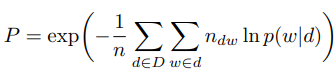


In [ ]:
model.score_tracker["perplexity_score"].last_value

671.355224609375

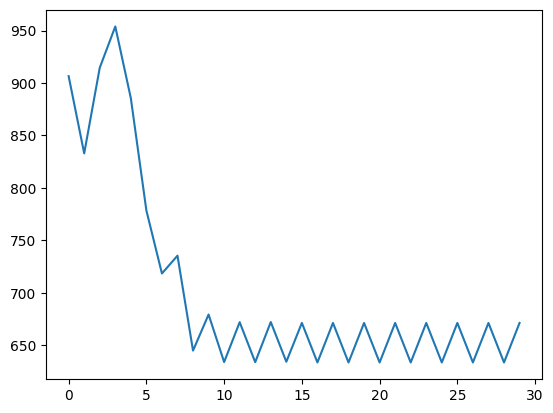

In [ ]:
plt.plot(model.score_tracker["perplexity_score"].value)

#### Sparsity

Sparsity Phi - доля элементов матрицы $\Phi$ (или ее части), которые меньше заданного порогового значения eps.

In [ ]:
model

artm.ARTM(num_topics=10, num_tokens=939)

In [ ]:
model.score_tracker["sparsity_phi_score"].last_value

0.503727376461029

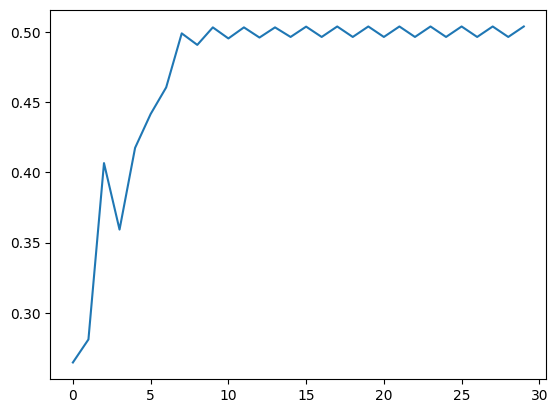

In [ ]:
plt.plot(model.score_tracker["sparsity_phi_score"].value)

Sparsity Theta - доля элементов матрицы $\Theta$ (или ее части), которые меньше заданного порогового значения eps.

In [ ]:
print(model.score_tracker["sparsity_theta_score"].last_value)

0.0


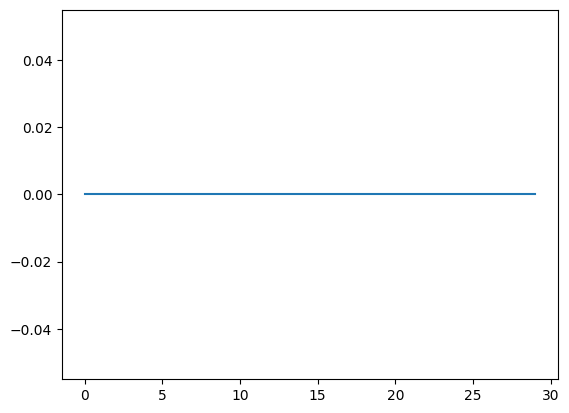

In [ ]:
plt.plot(model.score_tracker["sparsity_theta_score"].value)

#### Topic diversity

topic diversity - процент уникальных слов из топ num_words (10) слов для каждой из тем.

In [ ]:
num_words = 10

In [ ]:
word_topics = []

for topic_name in model.topic_names:
    temp = []
    for word in model.score_tracker["top_tokens_score"].last_tokens[topic_name]:
        temp.append(word)
        word_topics.append(temp)

In [ ]:
def td_score(topics):
    if topics is None:
        return 0
    if num_words > len(topics[0]):
        raise Exception('Words in topics are less than ' + str(num_words))
    else:
        unique_words = set()
        for topic in topics:
            unique_words = unique_words.union(set(topic[:num_words]))
        td = len(unique_words) / (num_words * len(topics))
        return td

In [ ]:
td_score(word_topics)

0.01

#### Coherence

Тематическая согласованность измеряет оценку одной темы путем измерения степени семантического сходства между высоко оцененными словами в теме

Показатель **c_v** извлекает количество совпадений для заданных слов с использованием скользящего окна. Счетчики используются для вычисления NPMI каждого топ-токена по отношению к другим топ-токенам, в результате чего получается набор векторов - по одному для каждого топ-токена. Сегментация по одному набору топ-токенов приводит к вычислению сходства между каждым вектором топ-токена и суммой всех векторов топ-токенов. В качестве меры сходства используется косинусное расстояние.

In [ ]:
docs = []

for row in n_wd.T:
    docs.append([token_list[i] for i, value in enumerate(row) if value > 0])

In [ ]:
dictionary = corpora.Dictionary(docs)

In [ ]:
coherence_model = CoherenceModel(topics=word_topics, texts=docs, dictionary=dictionary, coherence='c_v')
coherence = coherence_model.get_coherence()
coherence

0.6139406134094401

### Визуализация

Иногда по какой-то причине в матрице присутствуют значения > 1.0, которые в сумме дают большое число, вследствие чего деление на них даёт nan'ы, которые не дают визуализировать результаты через pyLDAvis.

In [ ]:
teta = model.get_theta().to_numpy().T
teta / teta.sum(axis=1, keepdims=1)

array([[0.09999993, 0.09999993, 0.09995178, ..., 0.0999758 , 0.0999758 ,
        0.09999993],
       [0.09999993, 0.09999993, 0.09995178, ..., 0.0999758 , 0.0999758 ,
        0.09999993],
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       ...,
       [0.1       , 0.1       , 0.1       , ..., 0.1       , 0.1       ,
        0.1       ],
       [0.09999993, 0.09999993, 0.09995178, ..., 0.0999758 , 0.0999758 ,
        0.09999993],
       [0.09999993, 0.09999993, 0.09995178, ..., 0.0999758 , 0.0999758 ,
        0.09999993]], dtype=float32)

In [ ]:
def prepare_vis_data():
    phi = model.get_phi()
    theta = model.get_theta().to_numpy().T
    theta = theta / theta.sum(axis=1, keepdims=1)
    data = {'topic_term_dists': phi.to_numpy().T,
            'doc_topic_dists': theta,
            'doc_lengths': n_wd.sum(axis=0).tolist(),
            'vocab': phi.T.columns,
            'term_frequency': n_wd.sum(axis=1).tolist()}
    return data

model_data = prepare_vis_data()
model_vis = pyLDAvis.prepare(**model_data)
pyLDAvis.save_html(model_vis, 'lenta_bigartm_vis.html')
pyLDAvis.display(model_vis)

#### Top tokens

In [ ]:
def print_top_tokens():
    top_tokens = model.score_tracker['top_tokens_score']

    for topic_name in model.topic_names:
        print(topic_name + ': ')
        for (token, weight) in zip(top_tokens.last_tokens[topic_name], top_tokens.last_weights[topic_name]):
            print(f'{round(weight, 3)}*{token}', end=' + ')
        print()

print_top_tokens()

Топ-10 токенов для каждой темы

In [ ]:
for topic_name in model.topic_names:
    print(topic_name + ': ')
    for word in model.score_tracker["top_tokens_score"].last_tokens[topic_name]:
        print(word, end=',')
    print()